<h2> Click Ads Probability Prediction using a Transformer.</h2>


<p>In this notebook, we are going to implement a transformer architecture. Only the decoder side on the transfomer to apply it to a click Ads probability prediction problem.</p>
<p> For such we will use as well a batchembedding class that will create an a cross embedding of all the features to be used in our dataset in order to form a representation that will be used to carry out the prediction.</p>
<p>The idea is that the model is to pay attention to the most relevant features that are necessary to predict the Click and as well provide an ability to determine the probability of a click even if all the features are not present.</p>
<p> Without further ado , let's dive into it.<p>

<h3> Importing the necessary libraries</h3>

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras


import os
import tempfile

import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
import imblearn

import sklearn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<p> Let's load our dataset.</p>

In [ ]:
 #/test3_data.csv
 #df=pd.read_csv("/content/drive/MyDrive/Datasets/test3_data.csv")
 df=pd.read_csv("/test3_data.csv")



# Display the imported data
df.head()

,Unnamed: 0,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
0,1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,View,Facebook,300x600,Carter's,Pink,0.171601
1,2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,View,Facebook,300x250,Burberry,Red,4.303945
2,3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,View,Facebook,728x90,Disney,Yellow,0.868106
3,4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,View,Facebook,320x50,Carter's,Yellow,0.802647
4,5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,View,instagram.com,300x250,Gap,Gold,0.627148


<p> As we an see, our <b> target</b> feature is going to be <b> Action</b></p>
<p> Let's compute the class weight for this dataset.</p>

In [ ]:
neg=len(df[df['Action']=='View'])
pos=len(df[df['Action']=='Click'])

print('Number of negative samples: ', neg)
print('Number of postive samples: ' , pos)

total=pos+neg
print('Total number of samples: ',total)

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (neg) / (total / 2.0)
weight_for_1 = (pos) / (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.4f}'.format(weight_for_0))
print('Weight for class 1: {:.4f}'.format(weight_for_1))


Number of negative samples:  999756
Number of postive samples:  244
Total number of samples:  1000000
Weight for class 0: 1.9995
Weight for class 1: 0.0005


<p> The class_weight computed above shows that there is a high level of imbalance between our two classes. The is of course will affect the behaviour of the model to be trained by on this imbalanced.</p>
<p> In order to ensure that our model is still able to predict <b>positive samples</b> as this is the minority class, we are going to introduce an approach based on three models:
<ul><li>the first two models will be trained on each data class samples separately.</li><li> the third model will combine the features extracted by the previous two models to make predictions.</li></ul>
</p>

<h3> Categorical features</h3>

<p>  We are going to transform all the <b>categorical</b> features of this datasets into categories codes that will be used to train our model.<p>


<h4>Action feature</h4>

In [ ]:
#let's transform the Action column to be a
# categorical data as this is our target column

#turn the action column into categorical data
#get list of values from the ation column

actions=df['Action'].unique()

print(actions)

# Apply the categorical value
df['Action'] = pd.Categorical(df['Action'], categories=actions)
df_2=df.copy()

#add the numerical data as a new column which will be removed
# later
df['Action_num']=df['Action'].astype('category').cat.codes
df['Action_View']=df['Action'].apply(lambda x: 1 if x=='View' else 0)
df['Action_Click']=df['Action'].apply(lambda x: 1 if x=='Click' else 0)
#df.drop('Action',axis=1,inplace=True
df['Action_View']=df['Action_View'].astype('int32')
df['Action_Click']=df['Action_Click'].astype('int32')
df.head()

['View' 'Click']


,Unnamed: 0,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime,Action_num,Action_View,Action_Click
0,1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,View,Facebook,300x600,Carter's,Pink,0.171601,0,1,0
1,2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,View,Facebook,300x250,Burberry,Red,4.303945,0,1,0
2,3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,View,Facebook,728x90,Disney,Yellow,0.868106,0,1,0
3,4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,View,Facebook,320x50,Carter's,Yellow,0.802647,0,1,0
4,5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,View,instagram.com,300x250,Gap,Gold,0.627148,0,1,0


<h4>Websites feature</h4>

In [ ]:
websites=df['Website'].unique()

print(websites)

# Apply the categorical value
df['Website'] = pd.Categorical(df['Website'], categories=websites)


#add the numerical data as a new column which will be removed
# later
df['Website_num']=df['Website'].astype('category').cat.codes

['Facebook' 'instagram.com' 'Kijiji' 'Sympatico' 'Atedra' 'Amazon' 'Other'
 'Twitter' 'Yahoo' 'TubeMogul' 'Craigslist.ca' 'Expedia' 'AOL' 'Youtube'
 'Weather' 'Wayfair']


<h4> Banner feature.</h4>

In [ ]:
#let's correct the 'Other' value of the 'BannerSize' column
#to 'other' only value.

df['BannerSize'].replace('Other', 'other', inplace=True)

#let's turn the values into numerical data
bannerSize=df['BannerSize'].unique()

print(bannerSize)

# Apply the categorical value
df['BannerSize'] = pd.Categorical(df['BannerSize'], categories=bannerSize)
df_2=df.copy()

#add the numerical data as a new column which will be removed
# later
df['BannerSize_num']=df['BannerSize'].astype('category').cat.codes


['300x600' '300x250' '728x90' '320x50' '160x600' '1x1' 'other' '1200x627'
 '320x480' '300x50' '320x100' '768x1024' '1536x2048' '750x125']


<h4>Brand feature</h4>

In [ ]:
#let's turn the values into numerical data
brand=df['Brand'].unique().tolist()

#brand=["Carter's" 'Burberry' 'Disney' 'Gap' 'gymboree' 'Old Navy' 'JoeFresh'
# 'Banana Republic' "The Children's Place" 'Zara']


print(brand)

# Apply the categorical value
df['Brand'] = pd.Categorical(df['Brand'], categories=brand)
df_2=df.copy()

#add the numerical data as a new column which will be removed
# later
df['Brand_num']=df['Brand'].astype('category').cat.codes


["Carter's", 'Burberry', 'Disney', 'Gap', 'gymboree', 'Old Navy', 'JoeFresh', 'Banana Republic', "The Children's Place", 'Zara']


<h4>Colour feature.</h4>

In [ ]:
#let's turn the values into numerical data
colour=df['colour'].unique().tolist()

colour=['Pink', 'Red', 'Yellow', 'Gold', 'Blue', 'White', 'other']

print(colour)

# Apply the categorical value
df['colour'] = pd.Categorical(df['colour'], categories=colour)
df_2=df.copy()

#add the numerical data as a new column which will be removed
# later
df['colour_num']=df['colour'].astype('category').cat.codes

['Pink', 'Red', 'Yellow', 'Gold', 'Blue', 'White', 'other']


<h3> Numerical feature</h3>
<p> Let's break our <b>ActionTime</b> feature into its various components.</p>

In [ ]:
#let's break the actionTime columns
#data Cleaning
#first, let's convert the columns data type into timestamp dtype
df['ActionTime']=df['ActionTime'].apply(pd.Timestamp,unit='us')

df['Year'] = df['ActionTime'].dt.year
df['Month'] = df['ActionTime'].dt.month
df['Day'] = df['ActionTime'].dt.day
df['Hour'] = df['ActionTime'].dt.hour
df['Min'] = df['ActionTime'].dt.minute
df['Sec'] = df['ActionTime'].dt.second


<h4>Checking for missing values.</h4>

In [ ]:
df.isnull().sum()

Unnamed: 0         0
ID                 0
ActionTime         0
Action             0
Website            0
BannerSize         0
Brand              0
colour             0
InteractionTime    8
Action_num         0
Action_View        0
Action_Click       0
Website_num        0
BannerSize_num     0
Brand_num          0
colour_num         0
Year               0
Month              0
Day                0
Hour               0
Min                0
Sec                0
dtype: int64

<p>From the above only the <b> InteractionTime feature</b> has missing values. Lets replace the missing values with zeros.</p>

In [ ]:
#filling the missing value with zero
df['InteractionTime'].fillna(0, inplace=True)

<p> After this, we are now ready to prepare our dataset for training. We will use a selected number of 11 features to train our model.<p>
<p> These features include: <ol><li>Year</li> <li>Month</li> <li>Day</li> <li>Hour</li><li>Min</li> <li>Sec</li><li>InteractionTime</li> <li>BannerSize_num</li><li>Brand_num</li> <li>colour_num</li> <li>Website_num</li></ol></p>

<p> Our target feature will be : Action_num</p>

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

features_to_use = ['Year', 'Month','Day','Hour','Min','Sec', 'InteractionTime', 'BannerSize_num',
                  'Brand_num', 'colour_num', 'Website_num','Action_num']


df_numeric = df[features_to_use ]

train_features = ['Year', 'Month','Day','Hour','Min','Sec', 'InteractionTime', 'BannerSize_num',
                  'Brand_num', 'colour_num', 'Website_num']

X = df_numeric[train_features]
y=df_numeric['Action_num']

print(X.shape,y.shape)
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=101)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.25,
                                                  random_state=101)

print(x_train.shape, y_train.shape,type(x_train))
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

#let's check the number of class samples per set
print(y_train.value_counts())
print(y_test.value_counts())


(1000000, 11) (1000000,)
(562500, 11) (562500,) <class 'pandas.core.frame.DataFrame'>
(187500, 11) (187500,)
(250000, 11) (250000,)
Action_num
0    562373
1       127
Name: count, dtype: int64
Action_num
0    249937
1        63
Name: count, dtype: int64


<p> The first splitting of the data above will be use to train our specialized models (Positive and Negative Models) for each class.</p>
<p> The second splitting below will be used to train and evaluate  our Combiner Model.</p>

In [ ]:
features_to_use = ['Year', 'Month','Day','Hour','Min','Sec', 'InteractionTime', 'BannerSize_num',
                   'Brand_num', 'colour_num', 'Website_num','Action_View','Action_Click']

df_numeric_2 = df[features_to_use ]

train_features = ['Year', 'Month','Day','Hour','Min','Sec', 'InteractionTime', 'BannerSize_num',
                  'Brand_num', 'colour_num', 'Website_num']

X_2 = df_numeric_2[train_features]
y_2 = df_numeric_2[['Action_View','Action_Click']]

print(X_2.shape,y_2.shape)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2,
                                                    test_size=0.25,
                                                    random_state=101)

x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_train_2, y_train_2,
                                                  test_size=0.25,
                                                  random_state=101)

print(x_train_2.shape, y_train_2.shape,type(x_train_2))
print(x_val_2.shape, y_val_2.shape)
print(x_test_2.shape, y_test_2.shape)

#let's check the number of class samples per set
print(y_train_2.value_counts())
print(y_test_2.value_counts())


(1000000, 11) (1000000, 2)
(562500, 11) (562500, 2) <class 'pandas.core.frame.DataFrame'>
(187500, 11) (187500, 2)
(250000, 11) (250000, 2)
Action_View  Action_Click
1            0               562373
0            1                  127
Name: count, dtype: int64
Action_View  Action_Click
1            0               249937
0            1                   63
Name: count, dtype: int64


In [ ]:
print(f'Average class probability in training set:   {y_train.mean():.4f}')
print(f'Average class probability in validation set: {y_val.mean():.4f}')
print(f'Average class probability in test set:       {y_test.mean():.4f}')

Average class probability in training set:   0.0002
Average class probability in validation set: 0.0003
Average class probability in test set:       0.0003


In [ ]:
#creating the datasets
dataset_train= tf.data.Dataset.from_tensor_slices((x_train,y_train))
dataset_val= tf.data.Dataset.from_tensor_slices((x_val,y_val))
dataset_test= tf.data.Dataset.from_tensor_slices((x_test,y_test))

#forming batches
batched_dataset_train = dataset_train.batch(2000)
batched_dataset_val = dataset_val.batch(2000)
batched_dataset_test = dataset_test.batch(2000)


batched_dataset_train


<_BatchDataset element_spec=(TensorSpec(shape=(None, 11), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int8, name=None))>

<p> Let's define  ColumnEmbedding Class that will generate an embedding for each features we will use.</p>

In [ ]:
class ColumnEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)


  def call(self, x):
    x = self.embedding(x)

    # This factor sets the relative scale of the embedding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    return x


<p> As well , let's define BatchEmbedding will will form the total embedding for each sample of data.</p>

In [ ]:
class BatchEmbedding(tf.keras.layers.Layer):
  def __init__(self,d_model,vocabs, list_features):
    super().__init__()
    #d_model is the embedding depth
    self.d_model=d_model
    #As each feature is different, we will have a different
    #vocab size
    self.X = vocabs
    self.list_features = list_features

    #initialize an embedding for each feature
    self.embed_features=self.initializeEmbedding()

  def getBatch(self,batch):
    batch=batch.map(self.makeBatchEmbedding)
    return batch

  def makeBatchEmbedding(self,x):

    batch_x_transp=tf.transpose(x)
    x_embed=[]
    j=0
    for el in self.list_features:

      #reshape feature tensor to create the feature embedding
      feature_values=tf.reshape(batch_x_transp[j],(-1,1))

      #create feature embedding
      feature_embed=self.embed_features[j](feature_values)
      j+=1

      #collect the features for future concatenation
      x_embed.append(feature_embed)

    #concatenate features
    x_embed=tf.concat(x_embed,axis=1)
    return x_embed

  #initialize the embedding for each column (feature)
  def initializeEmbedding(self):
    columns_embed=[]

    for el in self.list_features:

      feature_vocab=self.X[el].round().astype('int32').unique()

      vocab_size=np.max(feature_vocab)+1
      embed_feature = ColumnEmbedding(vocab_size, self.d_model)
      columns_embed.append(embed_feature)

    return columns_embed

  def call(self, x ):  #batched_dataset

    x_embed = self.makeBatchEmbedding(x)

    return x_embed


<p> Let's test it.</p>

In [ ]:
#defining our features list
train_features = ['Year', 'Month','Day','Hour','Min','Sec', 'InteractionTime', 'BannerSize_num',
                  'Brand_num', 'colour_num', 'Website_num']

#instanciating a BatchEmbedding object assumming a d_model=200
# X as our vocabulary for each feature and
#train_features as a list of features
batched_dataset_embed=BatchEmbedding(200,X,train_features)

#test dataset
sample_dataset=batched_dataset_train.take(1)

#extracting feature and class
x,y=sample_dataset.as_numpy_iterator().next()
print("x.shape:",x.shape);

#creating the embedding
x_embed=batched_dataset_embed(x)
print("x_embed.shape:",x_embed.shape)



x.shape: (2000, 11)
x_embed.shape: (2000, 11, 200)


<h2> The Transformer model</h2>

<p> We are going to implement a variant of the transfmormer model which has only the dcoder layer.</p>
<p>Let's declare some variables to be used by our transformer.</p>

In [ ]:
d_model=100  #embedding depth
dff=100
dropout_rate=0.1


<p> Let's build the different layers that will be used buy our transformer.</p>

In [ ]:
#BaseAttention Layer
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [ ]:
#Self Attention Layer
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

<p> Let's test it.</p>

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=4, key_dim=200)

x=batched_dataset_train.take(1).as_numpy_iterator().next()[0]
print("x.shape:", x.shape)

#creating the embedding
x_embed=batched_dataset_embed(x)

#apply attention layer
x_gsa=sample_gsa(x_embed)
print("x_gsa.shape:",x_gsa.shape)


x.shape: (2000, 11)
x_gsa.shape: (2000, 11, 200)


In [ ]:
#CausalSelfAttention Layer
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        #use_causal_mask = True
        )
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

<p> Let's test it.</p>

In [ ]:
sample_csa = CausalSelfAttention(num_heads=4, key_dim=512)

x=batched_dataset_train.take(1).as_numpy_iterator().next()[0]
print("x.shape:", x.shape)

#creating the embedding
x_embed=batched_dataset_embed(x)

#apply attention layer
x_csa=sample_csa(x_embed)
print("x_csa.shape:",x_csa.shape)



x.shape: (2000, 11)
x_csa.shape: (2000, 11, 200)


In [ ]:
#FeedForward Layer
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

<p> Let's test it.</p>

In [ ]:
sample_ffn = FeedForward(200, 11) #11 features only

x=batched_dataset_train.take(1).as_numpy_iterator().next()[0]
print("x.shape:", x.shape)

#creating the embedding
x_embed=batched_dataset_embed(x)

#apply feedforward layer
x_ffn=sample_ffn(x_embed)
print("x_ffn.shape:",x_ffn.shape)



x.shape: (2000, 11)
x_ffn.shape: (2000, 11, 200)


In [ ]:
#DecoderLayer
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)



    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.causal_self_attention(x)

    x = self.ffn(x)
    return x




<p>Let's test it</p>

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=200, num_heads=4, dff=11)

x=batched_dataset_train.take(1).as_numpy_iterator().next()[0]
print("x.shape:", x.shape)

#creating the embedding
x_embed=batched_dataset_embed(x)

#apply Decoder layer
x_sample_decoder_layer_output = sample_decoder_layer(x_embed)
print("x_sample_decoder_layer_output.shape:",x_sample_decoder_layer_output.shape)



x.shape: (2000, 11)
x_sample_decoder_layer_output.shape: (2000, 11, 200)


<h4> The Decoder </h4>

In [ ]:
# Decoder
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff,X,features_list,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.batch_embedding = BatchEmbedding(self.d_model,X,train_features)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x):

    x = self.batch_embedding(x)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x)

    return x

In [ ]:
#Test the decoder:

#X,
features_list=['Year', 'Month','Day','Hour','Min','Sec', 'InteractionTime', 'BannerSize_num',
                  'Brand_num', 'colour_num', 'Website_num']
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=1,
                         d_model=300,#100,
                         num_heads=4,
                         dff=11,
                         X=X,
                         features_list=features_list,
                         )

sample_dataset=batched_dataset_train.take(1)
x,y=sample_dataset.as_numpy_iterator().next()
print("x.shape:", x.shape)

x_output = sample_decoder(x)

print("x_output.shape:",x_output.shape)


x.shape: (2000, 11)
x_output.shape: (2000, 11, 300)


<h4> The Transformer </h4>

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,X,features_list,
               dropout_rate=0.1):
    super().__init__()

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           X=X,
                           features_list=features_list,
                           dropout_rate=dropout_rate)


    self.reduce_layer = tf.keras.layers.Flatten()


  def call(self, inputs):

    # just a single instance of our data...
    x  = inputs

    # calling our decoder
    x = self.decoder(x)  # (batch_size, target_len, d_model)

    #flattern the previous output
    x=self.reduce_layer(x)


    logits = x


    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output.
    return logits

<p> Let's try our transformer model.</p>

In [ ]:
#Try it out
#Instantiate the Transformer model:


features_list=['Year', 'Month','Day','Hour','Min','Sec', 'InteractionTime', 'BannerSize_num',
                  'Brand_num', 'colour_num', 'Website_num'],

transformer = Transformer(
    num_layers=3,
    d_model=100,
    num_heads=2,
    dff=11,
    X=X,
    features_list=features_list,
    dropout_rate=dropout_rate)


transformer_ = Transformer(
    num_layers=3,
    d_model=100,
    num_heads=2,
    dff=11,
    X=X,
    features_list=features_list,
    dropout_rate=dropout_rate)



<p> Let's test it.</p>

In [ ]:
#Test it:

sample_dataset=batched_dataset_train.take(1)
x,y=sample_dataset.as_numpy_iterator().next()
print(x.shape)

x_output = output = transformer(x)

print(x_output.shape)


(2000, 11)
(2000, 1100)


In [ ]:
transformer.summary()


Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_1 (Decoder)         multiple                  477133    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
Total params: 477133 (1.82 MB)
Trainable params: 477133 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<p>

<p> As one can see, our slight modified version of the transformer model only output a flattern tensor of values representing the extracted features from our dataset that will be used later on for classification purpose.</p>

<p> In this approach, we will use mainly the transformer to extract meaningful insight from our data, then used another model to train each data class set for classification.</p>
<p> In this view, we are goind to have two models: <ul><li>model_pos: trained on the data that lead to a click by the user</li> <li>model_neg: trained on the data that lead to a "view only" by the user</li></ul></p>
<p>The idea is to store the representation of all these features in the transformer model and used them later for a full classification by combining these two models.</p>

<p> Let's defined our two models.</p>

In [ ]:
#model_positive to train the positive class data
#in order to extract the features to be used from the data

model_pos=tf.keras.Sequential()
model_pos.add(transformer)
model_pos.add(tf.keras.layers.Dense(1,activation='sigmoid'))

#model_negative to train the positive class data
#in order to extract the features to be used from the data
model_neg=tf.keras.Sequential()
model_neg.add(transformer_)
model_neg.add(tf.keras.layers.Dense(1,activation='sigmoid'))


In [ ]:
#Test it:

sample_dataset=batched_dataset_train.take(1)
x,y=sample_dataset.as_numpy_iterator().next()
print(x.shape)

x_output_pos  = model_pos(x)
x_output_neg  = model_neg(x)

print("x_output_pos:", x_output_pos.shape)
print("x_output_neg:", x_output_neg.shape)

(2000, 11)
x_output_pos: (2000, 1)
x_output_neg: (2000, 1)


In [ ]:

model_pos.summary()
model_neg.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (Transformer)   (2000, 1100)              477133    
                                                                 
 dense_22 (Dense)            (2000, 1)                 1101      
                                                                 
Total params: 478234 (1.82 MB)
Trainable params: 478234 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_1 (Transformer  (2000, 1100)              477133    
 )                                                               
                                                                 
 dense_23 (Dense)            (2000, 1)                 1101 

<p> As one can see, the two models looks alike.</p>

<h3> The Combiner </h3>

<p> The model is going to be use to combined the two trained previous model for classification.The idea here is to give a chance to each class to at least be "known" by the model. Because we are dealing with a very huge imbalanced dataset, training the whole model once will cause the positive samples to become almost inexistant for the model.</p>

In [ ]:
class Combiner(tf.keras.Model):
  def __init__(self, *, transformer_pos:tf.keras.Model, transformer_neg:tf.keras.Model):
    super().__init__()

    #transformer model specialized on positive samples
    self.trans_pos=transformer_pos

    #transformer model specialized on negative samples
    self.trans_neg=transformer_neg

    #layer norm
    self.layernorm = tf.keras.layers.LayerNormalization()
    #two dense layers
    self.previous_layer = tf.keras.layers.Dense(1200) #for binary classification in our case

    self.previous_layer_1 = tf.keras.layers.Dense(1200) #for binary classification in our case

    self.final_layer = tf.keras.layers.Dense(2, activation='softmax')


  def call(self, inputs):
    x  = inputs
    output_pos=self.trans_pos(x)
    output_neg=self.trans_neg(x)

    x=tf.concat([output_pos,output_neg],axis=1)



    x=self.previous_layer(x)
    x=self.layernorm(x)

    x=self.previous_layer_1(x)

    # Final linear layer output.
    logits = self.final_layer(x)



#    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
 #     del logits._keras_mask
  #  except AttributeError:
  #    pass

    # Return the final output and the attention weights.
    return logits

<h3> Training </h3>

<p> Let's create a scheduler and an optimizer to train our model.</p>

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

optimizer_1 = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

optimizer_2 = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)



In [ ]:
#Metrics to be monitored
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]



<p> Next , let's split the train set into positive and negative smaples.</p>

In [ ]:
#split
x_train_pos=x_train[y_train==1]
x_train_neg=x_train[y_train==0]

y_train_pos=y_train[y_train==1]
y_train_neg=y_train[y_train==0]





<p> Let's compile and train both models.</p>

<h4> The Positive Model </h4>

In [ ]:

model_pos.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=METRICS)

EPOCHS = 20
BATCH_SIZE = 2000


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model_weights_train_pos = os.path.join('/', 'model_weights_train_pos')

model_pos.load_weights( model_weights_train_pos)
baseline_history_pos = model_pos.fit(
    x_train_pos,
    y_train_pos,
    batch_size=20,
    epochs=EPOCHS,
    validation_data= (x_val, y_val))



Epoch 1/10
7/7 [==============================] - 41s 6s/step - loss: 0.1229 - cross entropy: 2.5376 - Brier score: 0.7889 - tp: 178.0000 - fp: 184872.0000 - tn: 2574.0000 - fn: 3.0000 - accuracy: 0.0147 - precision: 9.6190e-04 - recall: 0.9834 - auc: 0.5262 - prc: 0.0010 - val_loss: 2.8180 - val_cross entropy: 2.8180 - val_Brier score: 0.8318 - val_tp: 54.0000 - val_fp: 186221.0000 - val_tn: 1225.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0068 - val_precision: 2.8989e-04 - val_recall: 1.0000 - val_auc: 0.4790 - val_prc: 2.8266e-04
Epoch 2/10
7/7 [==============================] - 41s 7s/step - loss: 0.0990 - cross entropy: 0.0990 - Brier score: 0.0177 - tp: 126.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 1.0000 - accuracy: 0.9921 - precision: 1.0000 - recall: 0.9921 - auc: 0.0000e+00 - prc: 1.0000 - val_loss: 3.1010 - val_cross entropy: 3.1010 - val_Brier score: 0.8672 - val_tp: 54.0000 - val_fp: 186876.0000 - val_tn: 570.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0033 - val_precis

In [ ]:
#save model weight
model_weights_train_pos = os.path.join('/', 'model_weights_train_pos')

model_pos.save_weights( model_weights_train_pos)

<h4> Check Train History</h4>

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


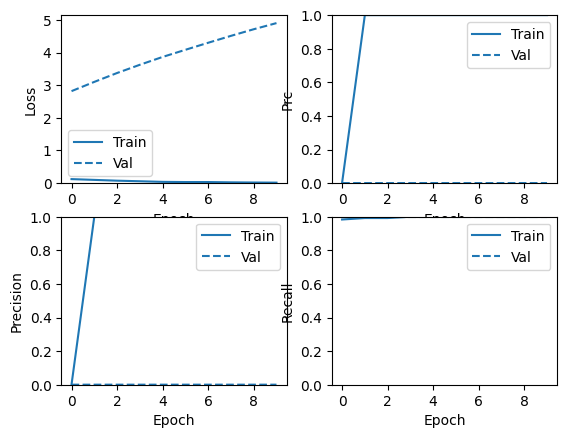

In [ ]:
plot_metrics(baseline_history_pos)

<h4> Evaluate Metrics</h4>

In [ ]:
train_predictions_baseline = model_pos.predict(x_train, batch_size=BATCH_SIZE)
val_predictions_baseline = model_pos.predict(x_val, batch_size=BATCH_SIZE)
test_predictions_baseline = model_pos.predict(x_test, batch_size=BATCH_SIZE)


125/125 [==============================] - 4s 28ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)

  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print(' TN(True Negatives): ', cm[0][0])
  print(' FP(False Positives): ', cm[0][1])
  print(' FN(False Negatives): ', cm[1][0])
  print(' TP(True Positives): ', cm[1][1])


              precision    recall  f1-score   support

           0       1.00      0.00      0.00    249937
           1       0.00      1.00      0.00        63

    accuracy                           0.00    250000
   macro avg       0.50      0.50      0.00    250000
weighted avg       1.00      0.00      0.00    250000

 TN(True Negatives):  1
 FP(False Positives):  249936
 FN(False Negatives):  0
 TP(True Positives):  63


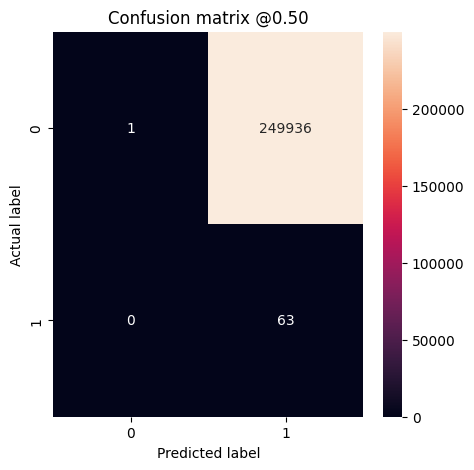

In [ ]:
print(classification_report(y_test.to_numpy(), test_predictions_baseline>.5))

plot_cm(y_test, test_predictions_baseline)



<h4> The Negative Model</h4>

In [ ]:

EPOCHS = 20
BATCH_SIZE = 2000


model_neg.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=optimizer_1,
    metrics=METRICS)


early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', #'val_auc' ,#
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


baseline_history = model_neg.fit(
    x_train_neg,
    y_train_neg,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    #steps_per_epoch=20,
    validation_data= (x_val, y_val))



Epoch 1/20
282/282 [==============================] - 29s 86ms/step - loss: 0.0284 - cross entropy: 0.0906 - Brier score: 0.0229 - tp: 6.0000 - fp: 16909.0000 - tn: 732910.0000 - fn: 48.0000 - accuracy: 0.9774 - precision: 3.5471e-04 - recall: 0.1111 - auc: 0.8386 - prc: 2.6715e-04 - val_loss: 0.0028 - val_cross entropy: 0.0028 - val_Brier score: 2.8794e-04 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 187446.0000 - val_fn: 54.0000 - val_accuracy: 0.9997 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 2.8800e-04
Epoch 2/20
282/282 [==============================] - 23s 82ms/step - loss: 3.9262e-05 - cross entropy: 3.9262e-05 - Brier score: 8.2100e-09 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 562373.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00 - val_loss: 0.0038 - val_cross entropy: 0.0038 - val_Brier score: 2.8800e-04 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 187

<p> Let's save the negative model as well .</p>

In [ ]:

model_weights_train_neg = os.path.join('/', 'model_weights_train_neg')

model_neg.save_weights( model_weights_train_neg)

<h4> Check train history</h4>

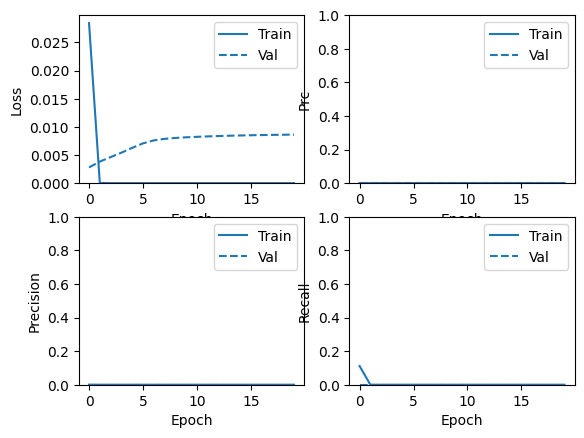

In [ ]:
plot_metrics(baseline_history)

<h4> Evaluate Metrics</h4>

In [ ]:
train_predictions_baseline = model_neg.predict(x_train, batch_size=BATCH_SIZE)
val_predictions_baseline = model_neg.predict(x_val, batch_size=BATCH_SIZE)
test_predictions_baseline = model_neg.predict(x_test, batch_size=BATCH_SIZE)


125/125 [==============================] - 3s 27ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    249937
           1       0.00      0.00      0.00        63

    accuracy                           1.00    250000
   macro avg       0.50      0.50      0.50    250000
weighted avg       1.00      1.00      1.00    250000

 TN(True Negatives):  249937
 FP(False Positives):  0
 FN(False Negatives):  63
 TP(True Positives):  0


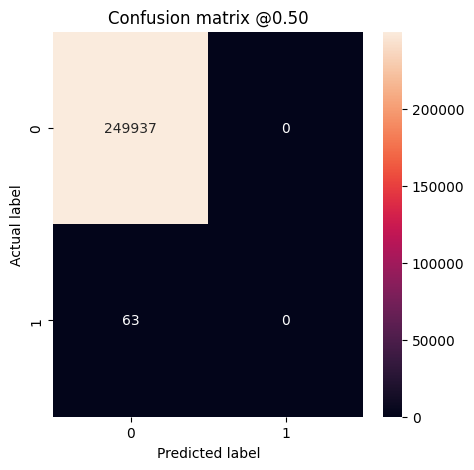

In [ ]:
print(classification_report(y_test.to_numpy(), test_predictions_baseline>.5))

plot_cm(y_test, test_predictions_baseline)

<p> As expected both models overfit on the data and though they tend to classifiy correctly each class, they can't actually differiante each class.</p>
<p> To tackle this, we are going to combined both models in our Combiner Model shown below.</p>

<h3> Training the Combiner Model</h3>

<p> Here we are going to oversample the minority class(positive) in oder to have a balanced dataset in instead used the oversampled data to train our Combiner model.</p>

In [ ]:
# Oversample the dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
#oversample the minority class
# transform the dataset
oversample = SMOTE()
x_train_2_over_s, y_train_2_over_s = oversample.fit_resample(x_train, y_train)
# summarize the new class distribution
#counter = Counter(y)
counter=Counter(y_train_2_over_s)
print(counter)

Counter({0: 562373, 1: 562373})


<p> As we are combining both models, we are going to have the two outputs as target for our Combiner Model.</p>
<p> Because of that we need to turn our target into a 2 dimensional array.</p>

In [ ]:
def map_to_array(x):
  if(x==0):
    return np.array([1,0])
  else:
    return np.array([0,1])

#mapping each sample to the equivalent array
y_train_2_over_s_2=np.array(list(map(map_to_array,y_train_2_over_s)))
print(y_train_2_over_s_2.shape)

(1124746, 2)


<p>Now, we'll need the number of steps per epoch.

The definition of "epoch" here is going to be the number of batches required to see each negative example once:
</p>

In [ ]:
neg=562373
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

563.0

<p>Now let's remove the final layer in both models and combine them using our combiner model.</p>

In [ ]:
#reloads models
model_weights_train_pos = os.path.join('/', 'model_weights_train_pos')
#transformer_os.load_weights(model_weights_train) #,by_name=True,skip_mismatch=True)
model_pos.load_weights(model_weights_train_pos)


model_weights_train_neg = os.path.join('/', 'model_weights_train_neg')
model_neg.load_weights(model_weights_train_neg)

model_pos.pop()
model_neg.pop()

model_pos.trainable=False
model_neg.trainable=False




In [ ]:
output_pos=model_pos(x)
output_neg=model_neg(x)


print("output_neg.shape:",output_neg.shape)

output_neg.shape: (2000, 1100)


In [ ]:
#let's create an instance on the Combiner Model
model_combined=Combiner(transformer_pos=model_pos,
                        transformer_neg=model_neg)

output=model_combined(x)
print("output.shape:",output.shape)
model_combined.summary()


output.shape: (2000, 2)
Model: "combiner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (2000, 1100)              477133    
                                                                 
 sequential_12 (Sequential)  (None, 1100)              477133    
                                                                 
 layer_normalization_23 (La  multiple                  2400      
 yerNormalization)                                               
                                                                 
 dense_24 (Dense)            multiple                  2641200   
                                                                 
 dense_25 (Dense)            multiple                  1441200   
                                                                 
 dense_26 (Dense)            multiple                  2402      
                                  

<p> Let's compile and run the model.</p>

In [ ]:
#Metrics to be monitored
METRICS = [
      keras.metrics.CategoricalCrossentropy(name='cross entropy'),
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model_combined.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=optimizer_2,
    metrics=METRICS)


In [ ]:
EPOCHS =40 #
BATCH_SIZE = 2000



early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


baseline_history = model_combined.fit(
    x_train_2_over_s,
    y_train_2_over_s_2,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=563,
    validation_data= (x_val_2, y_val_2))



Epoch 1/40
563/563 [==============================] - 51s 78ms/step - loss: 0.4675 - cross entropy: 0.4675 - Brier score: 0.1546 - accuracy: 0.7704 - precision: 0.7704 - recall: 0.7704 - auc: 0.8576 - prc: 0.8594 - val_loss: 0.3500 - val_cross entropy: 0.3500 - val_Brier score: 0.1109 - val_accuracy: 0.8427 - val_precision: 0.8427 - val_recall: 0.8427 - val_auc: 0.9249 - val_prc: 0.9264
Epoch 2/40
563/563 [==============================] - 44s 78ms/step - loss: 0.4241 - cross entropy: 0.4241 - Brier score: 0.1388 - accuracy: 0.7949 - precision: 0.7949 - recall: 0.7949 - auc: 0.8843 - prc: 0.8867 - val_loss: 0.4752 - val_cross entropy: 0.4752 - val_Brier score: 0.1578 - val_accuracy: 0.7635 - val_precision: 0.7635 - val_recall: 0.7635 - val_auc: 0.8547 - val_prc: 0.8580
Epoch 3/40
563/563 [==============================] - 49s 88ms/step - loss: 0.4215 - cross entropy: 0.4215 - Brier score: 0.1381 - accuracy: 0.7958 - precision: 0.7958 - recall: 0.7958 - auc: 0.8856 - prc: 0.8883 - val_l

<p> Save the model.</p>

In [ ]:
model_weights_train_combined = os.path.join('/', 'model_weights_train_combined')

model_combined.save_weights( model_weights_train_combined)

<h4> Check Train History</h4>

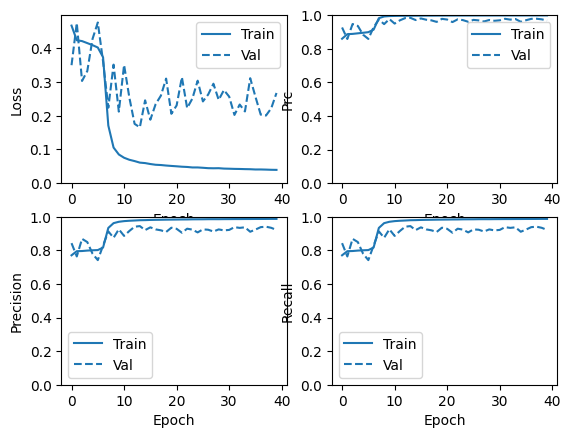

In [ ]:
plot_metrics(baseline_history)

<h4> Evaluate metrics</h4>

In [ ]:
train_predictions_baseline = model_combined.predict(x_train_2, batch_size=BATCH_SIZE)
val_predictions_baseline = model_combined.predict(x_val_2, batch_size=BATCH_SIZE)
test_predictions_baseline = model_combined.predict(x_test_2, batch_size=BATCH_SIZE)





125/125 [==============================] - 8s 60ms/step


In [ ]:
def plot_cm_2(cm):

  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix ')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print(' TN(True Negatives): ', cm[0][0])
  print(' FP(False Positives): ', cm[0][1])
  print(' FN(False Negatives): ', cm[1][0])
  print(' TP(True Positives): ', cm[1][1])


              precision    recall  f1-score   support

           0       1.00      0.92      0.96    249937
           1       0.00      0.16      0.00        63

    accuracy                           0.92    250000
   macro avg       0.50      0.54      0.48    250000
weighted avg       1.00      0.92      0.96    250000

 TN(True Negatives):  230208
 FP(False Positives):  19729
 FN(False Negatives):  53
 TP(True Positives):  10


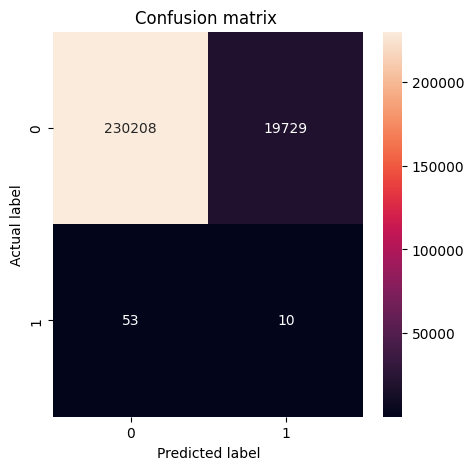

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#train set
#print(classification_report(y_train_2.to_numpy().argmax(axis=1), train_predictions_baseline.argmax(axis=1)))
#confusion_matrix(y_train_2.to_numpy().argmax(axis=1), train_predictions_baseline.argmax(axis=1))

# val set
#print(classification_report(y_val_2.to_numpy().argmax(axis=1), val_predictions_baseline.argmax(axis=1)))
#cm_val=confusion_matrix(y_val_2.to_numpy().argmax(axis=1), val_predictions_baseline.argmax(axis=1))
#print(cm_val)

# test set
print(classification_report(y_test_2.to_numpy().argmax(axis=1), test_predictions_baseline.argmax(axis=1)))
cm_test=confusion_matrix(y_test_2.to_numpy().argmax(axis=1), test_predictions_baseline.argmax(axis=1))
plot_cm_2(cm_test)


<h3> Key Takeways </h3>
<p> As we can see, dealing with imbalanced datasets can be complex. This complexity is usually due to the fact that there is not enough training samples for the minority class.</p>
<p> As shown belown combining pretrained specialized models can produce better results as it forces the model to contain the information pertaining to the minority class.</p>
<p> Training a single model would have tuned all its weights according to the class having the highest number of occurences. Which will eventually caused the model to loose the information of the minority class.</p>
<p> This approach also allows the model to determine the weight of each feature as well as how much they impact the task at hand.</p>  
<p> Of course, much still need to be done to find the appropriate model that can be used to handle such task more effectively. </p>
<p> From the classification report above, one can see that a good model is the one which provide a good trade off between the <b> recall values</b> of both classes.</p>